<a href="https://colab.research.google.com/github/XieN-N/Human-or-Horse-model/blob/main/Human_or_Horse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3500)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

print(tf.__version__)
print(tf.executing_eagerly())

1 Physical GPU, 1 Logical GPUs
2.17.0
True


In [ ]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)

In [ ]:
os.listdir('data/horse-or-human/train')

['humans', 'horses']

In [ ]:
import PIL
from PIL import Image
def load_dataset(train=True):
    if train:
        counter = 0
        for variant in os.listdir('data/horse-or-human/train'):
            files = glob(f'data/horse-or-human/train/{variant}/*.png')
            counter += len(files)

        X = np.zeros((counter, IMG_SIZE[0], IMG_SIZE[1], 3))
        y = np.zeros((counter,))

        i = 0
        j = 0
        for variant in os.listdir('data/horse-or-human/train'):
            files = glob(f'data/horse-or-human/train/{variant}/*.png')
            for animal in files:
                img = cv2.imread(f'{animal}')
                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(rgb_img, (224, 224))
                img_np = np.array(img)
                X[i] = img_np
                y[i] = j
                i+=1
            j+=1
    else:
        counter = 0
        for variant in os.listdir('data/horse-or-human/validation'):
            files = glob(f'data/horse-or-human/validation/{variant}/*.png')
            counter += len(files)

        X = np.zeros((counter, IMG_SIZE[0], IMG_SIZE[1], 3))
        y = np.zeros((counter,))

        i = 0
        j = 0
        for variant in os.listdir('data/horse-or-human/train'):
            files = glob(f'data/horse-or-human/validation/{variant}/*.png')
            for animal in files:
                img = cv2.imread(f'{animal}')
                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(rgb_img, (224, 224))
                img_np = np.array(img)
                X[i] = img_np
                y[i] = j
                i+=1
            j+=1
    return (X, y)

In [ ]:
X_train, y_train = load_dataset()
X_test, y_test = load_dataset(train=False)

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_train_cat.shape, y_test_cat.shape

((1026, 2), (256, 2))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_cat, test_size=0.2)

In [ ]:
shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
y_test = y_test_cat[shuffler]

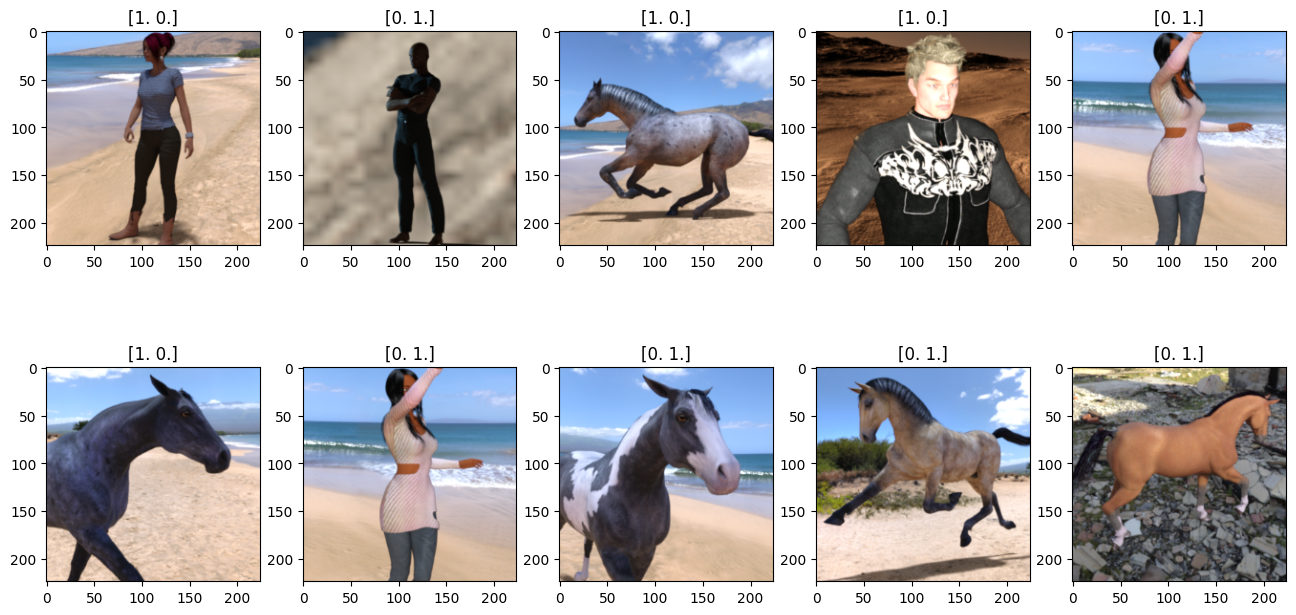

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(X_train[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    plt.title(f'{y_train[i]}')
    plt.imshow(path/255)

In [ ]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='irises')

In [ ]:
model.summary()

Model: "irises"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │       200,706 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,835,970 (29.89 MB)

 Trainable params: 200,706 (784.01 KB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=10, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8719 - loss: 22.4844 - val_accuracy: 1.0000 - val_loss: 0.6219
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 1.0000 - loss: 0.0753 - val_accuracy: 1.0000 - val_loss: 0.2912
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 1.0000 - loss: 0.0753 - val_accuracy: 1.0000 - val_loss: 0.2917
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 1.0000 - loss: 0.0753 - val_accuracy: 1.0000 - val_loss: 0.2921
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 1.0000 - loss: 0.0752 - val_accuracy: 1.0000 - val_loss: 0.2925


In [ ]:
model.save('humans-or-horses-vgg16.hdf5')

In [ ]:
#model = tf.keras.models.load_model('irises-vgg16.hdf5')

In [ ]:
model.evaluate(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9511 - loss: 15.4790


[15.221151351928711, 0.94921875]

In [ ]:
pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


In [ ]:
def from_softmax_to_animal(a):
    if a[0] == 1:
        return 'human'
    elif a[1] == 1:
        return 'horse'
    else:
        return 'Failure'

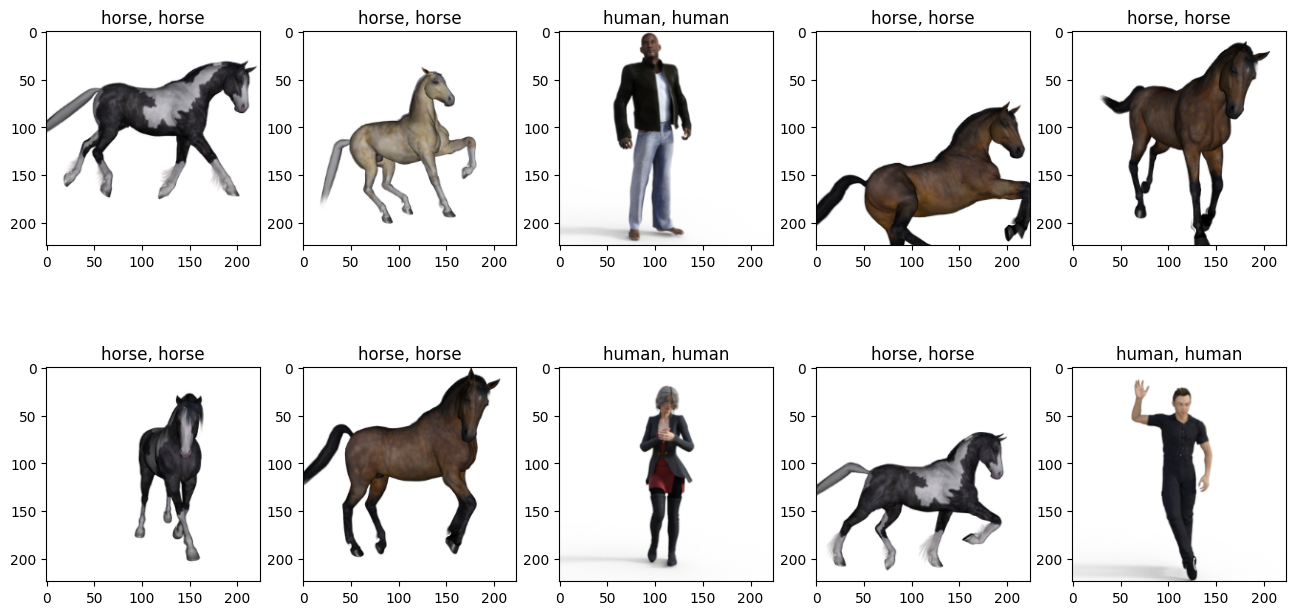

In [ ]:
fig = plt.figure(figsize=(16, 8))
length = 10
for i, path, score, real in zip(range(length), X_test[:length], pred[:length], y_test[:length]):
    subplot = fig.add_subplot(int(length/5), 5, i+1)
    subplot.set_title(f'{from_softmax_to_animal(score)}, {from_softmax_to_animal(real)}') # subplot.set_title('%.2f %s' % (score, os.path.basename(path))
    #plt.imshow(path/255)
    subplot.imshow(path/255)

Real: horse
Prediction: horse


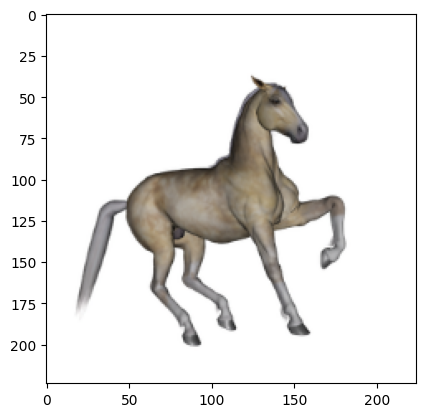

In [ ]:
index = 1

print(f'Real: {from_softmax_to_animal(y_test[index])}')
print(f'Prediction: {from_softmax_to_animal(pred[index])}')

plt.imshow(X_test[index]/255)

In [ ]:
img = cv2.imread('1.jpeg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(rgb_img, (224, 224))
img_np = np.array(img)
img_np = np.expand_dims(img_np, axis=0)
img_np.shape

(1, 224, 224, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
human


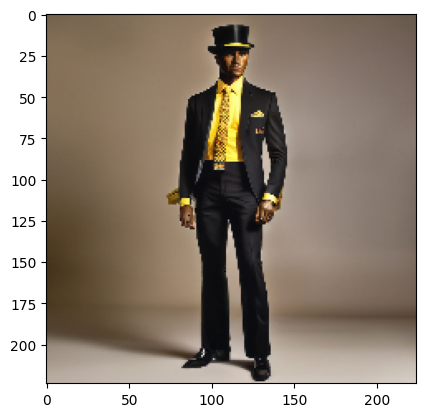

In [ ]:
prediction = model.predict(img_np)
print(from_softmax_to_animal(prediction[0]))
plt.imshow(img_np[0])